# GuessIt Characters Builder (Manual)
In this notebook we'll define the game's characters, their features, render them and analyze the distribution.

Firstly, we'll create the dataset:

In [78]:
import random
import pandas as pd


def shuffle(seed: int, items: list) -> list:
    new_list = list(items)
    random.Random(seed).shuffle(new_list)
    return new_list


skins = shuffle(15, items=12 * ["Brown"] + 12 * ["White"])
hair_colors = shuffle(17, items=11 * ["Black"] + 6 * ["Blonde"] + 7 * ["Ginger"])
eye_colors = shuffle(10, items=12 * ["Brown"] + 5 * ["Blue"] + 9 * ["Green"])
expressions = shuffle(13, items=12 * ["Neutral"] + 8 * ["Happy"] + 4 * ["Angry"])
glasses = shuffle(18, items=12 * ["None"] + 6 * ["Rectangular"] + 6 * ["Rounded"])
hat = shuffle(3, items=13 * ["None"] + 5 * ["Baseball Cap"] + 6 * ["Beanie"])


data = pd.DataFrame(
    columns=[
        "Name",
        "Gender",
        "SkinTone",
        "HairColor",
        "EyesColor",
        "Expression",
        "Glasses",
        "Hat",
    ]
)
names = [
    "Corey",
    "Rosario",
    "Susanne",
    "Ralph",
    "Doris",
    "Elmer",
    "Yolanda",
    "Richard",
    "Michele",
    "Vince",
    "Violet",
    "Isaac",
    "Tiffany",
    "Joey",
    "Sabrina",
    "Bernard",
    "Charlene",
    "Hugo",
    "Kelli",
    "Clayton",
    "Celia",
    "Marcus",
    "Mayra",
    "Perry",
]
for i in range(24):
    data.loc[i] = {
        "Name": names[i],
        "Gender": "Male" if i % 2 == 1 else "Female",
        "SkinTone": skins[i],
        "HairColor": hair_colors[i],
        "EyesColor": eye_colors[i],
        "Expression": expressions[i],
        "Glasses": glasses[i],
        "Hat": hat[i],
    }

print(data)

        Name  Gender SkinTone HairColor EyesColor Expression      Glasses  \
0      Corey  Female    Brown    Ginger      Blue      Happy         None   
1    Rosario    Male    Brown    Ginger     Green      Happy  Rectangular   
2    Susanne  Female    White     Black     Green      Happy         None   
3      Ralph    Male    White     Black     Brown      Angry      Rounded   
4      Doris  Female    White    Blonde     Brown    Neutral         None   
5      Elmer    Male    White     Black     Brown      Happy         None   
6    Yolanda  Female    Brown     Black     Brown      Happy      Rounded   
7    Richard    Male    Brown    Ginger     Green    Neutral         None   
8    Michele  Female    White    Ginger     Brown    Neutral      Rounded   
9      Vince    Male    White     Black     Brown    Neutral      Rounded   
10    Violet  Female    White    Ginger     Green      Happy  Rectangular   
11     Isaac    Male    Brown     Black     Green    Neutral  Rectangular   

Next, we need to analyze the data, and validate its quality:

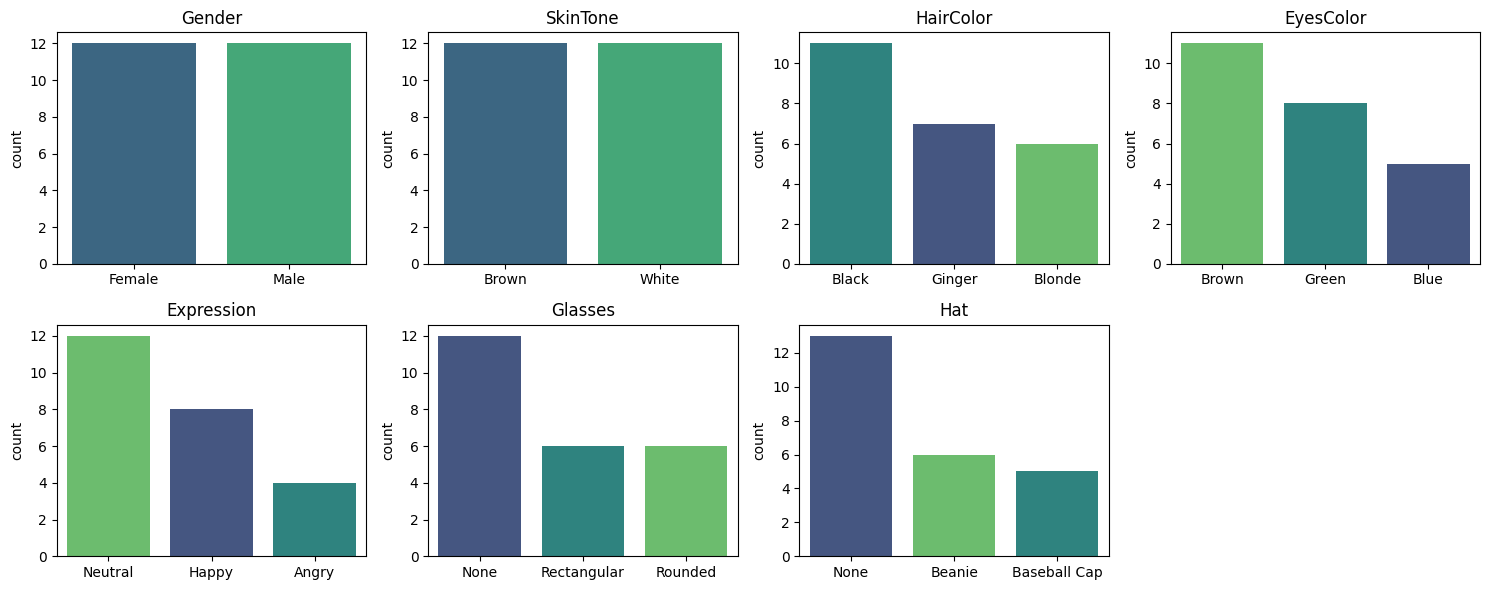

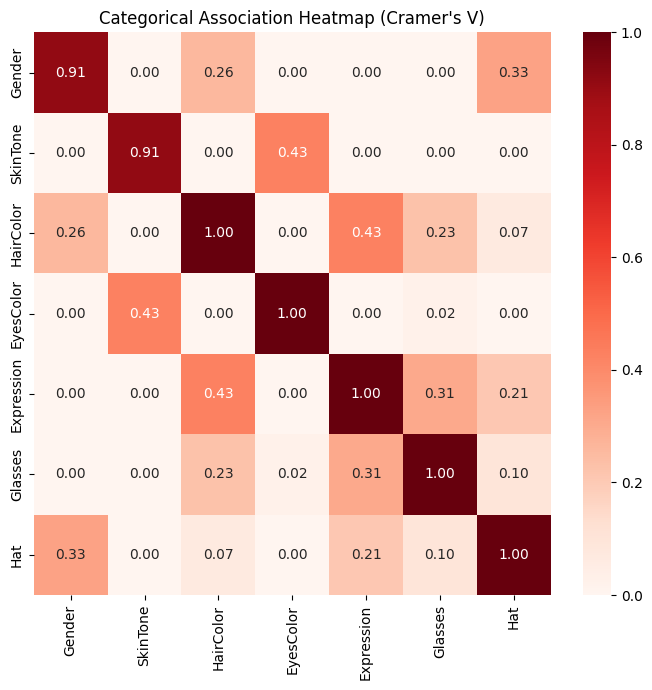

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency


# 1. Feature Distribution Plots
def plot_distributions(df):
    # Exclude unique identifiers like 'Name'
    cols_to_plot = [col for col in df.columns if col != "Name"]
    n_cols = 4
    n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cols_to_plot):
        # Sort bars by frequency for better readability
        order = df[col].value_counts().index
        sns.countplot(data=df, x=col, ax=axes[i], order=order, palette="viridis", hue=col)
        axes[i].set_title(col)
        axes[i].set_xlabel(None)
        # axes[i].tick_params(axis="x", rotation=45)

    # Remove any extra empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()


# 2. Correlation Matrix (Cramer's V)
def cramers_v(x, y):
    """Calculates Cramer's V statistic for categorical-categorical association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # Bias correction
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


def plot_correlations(df):
    cols = [col for col in df.columns if col != "Name"]
    corr_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)

    for col1 in cols:
        for col2 in cols:
            corr_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

    plt.figure(figsize=(7, 7))
    sns.heatmap(corr_matrix, annot=True, cmap="Reds", fmt=".2f", vmin=0, vmax=1)
    plt.title("Categorical Association Heatmap (Cramer's V)")
    plt.tight_layout()


plot_distributions(data)
plot_correlations(data)

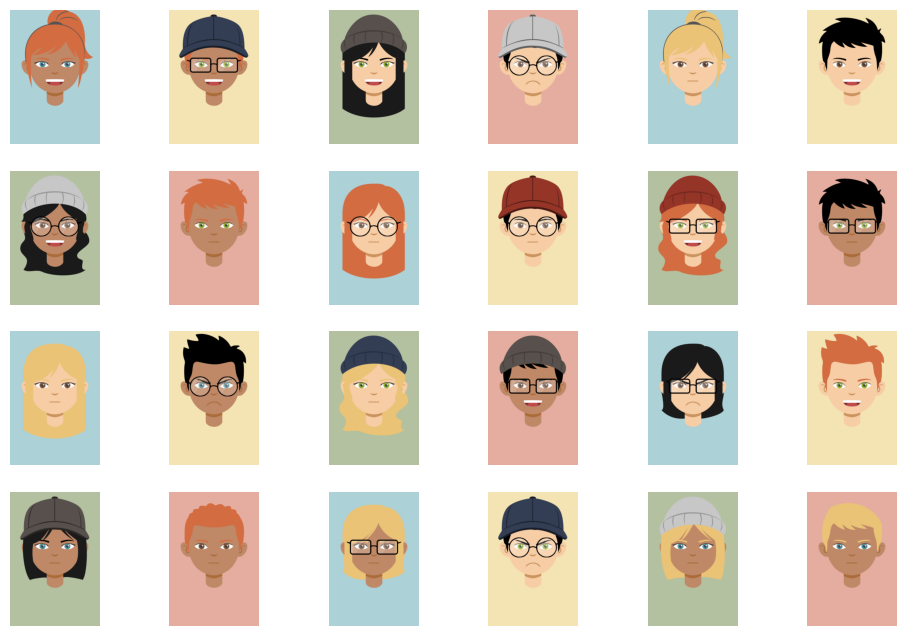

In [80]:
import itertools
import os

os.environ["PATH"] += os.pathsep + r"C:\Program Files\UniConvertor-2.0rc5\dlls"

import io
import cairosvg
from typing import Any, Dict, Tuple
import matplotlib.pyplot as plt
from PIL import Image


def get_layer(path, colors: Tuple[str, str] = None, info: Dict[str, Any] = None) -> Image.Image:
    with open(path, "r") as f:
        svg_data = f.read()

    # 1. Modify colors if a map is provided
    if colors:
        svg_data = svg_data.replace(colors[0], colors[1])

    # 2. Convert SVG string to PNG bytes using CairoSVG
    # CairoSVG handles transparency perfectly by default
    png_bytes = cairosvg.svg2png(bytestring=svg_data.encode("utf-8"))
    img = Image.open(io.BytesIO(png_bytes)).convert("RGBA")
    if info:
        img.info |= info
    return img


def create_character(row: pd.Series) -> Image.Image:
    base = Image.new("RGBA", skin[row["SkinTone"]].size, next(BG_COLORS))

    base.alpha_composite(skin[row["SkinTone"]])

    # Add Eyebrows
    if row["Expression"] == "Angry":
        base.alpha_composite(eyebrows_angry[row["HairColor"]])
    else:
        base.alpha_composite(eyebrows_neutral[row["HairColor"]])

    # Add Mount
    if row["Expression"] == "Neutral":
        base.alpha_composite(mouth_natural)
    if row["Expression"] == "Angry":
        base.alpha_composite(mouth_upset)
    if row["Expression"] == "Happy":
        base.alpha_composite(mouth_happy)

    # Add Eyes+Hair
    if row["Gender"] == "Male":
        base.alpha_composite(eyes_male[row["EyesColor"]])
        base.alpha_composite(next((i for i in hair_male[row["HairColor"]] if row["Hat"] == "None" or i.info["hat_compatiple"])))
    else:
        base.alpha_composite(eyes_female[row["EyesColor"]])
        base.alpha_composite(next((i for i in hair_female[row["HairColor"]] if row["Hat"] == "None" or i.info["hat_compatiple"])))

    # Add Glasses
    if row["Glasses"] == "Rounded":
        base.alpha_composite(glasses_rounded)
    if row["Glasses"] == "Rectangular":
        base.alpha_composite(glasses_rectangular)

    # Add Hat
    if row["Hat"] != "None":
        base.alpha_composite(next(hat[row["Hat"]]))

    base.info["name"] = row["Name"]
    return base


# Load and stack
BG_COLORS = itertools.cycle(["#acd1d7", "#f4e4b3", "#b3c1a0", "#e5ada0"])
BLONDE_COLOR = "#eac376"
GINGER_COLOR = "#d36c41"
EYE_GREEN_COLOR = "#8faf34"
EYE_BLUE_COLOR = "#528f9b"
DARK_SKIN_COLOR = "#bf8867"
HAT_COLOR_WHITE = "#c7c7c7"
HAT_COLOR_RED = "#953528"
HAT_COLOR_GREY = "#57504c"

skin = {"White": get_layer("svgs/skin.svg"), "Brown": get_layer("svgs/skin.svg", ("#f7cda5", DARK_SKIN_COLOR))}
hat = {
    "Baseball Cap": itertools.cycle(
        [
            get_layer("svgs/cap.svg"),
            get_layer("svgs/cap.svg", colors=("#333e54", HAT_COLOR_WHITE)),
            get_layer("svgs/cap.svg", colors=("#333e54", HAT_COLOR_RED)),
            get_layer("svgs/cap.svg", colors=("#333e54", HAT_COLOR_GREY)),
        ]
    ),
    "Beanie": itertools.cycle(
        shuffle(
            24237,
            items=[
                get_layer("svgs/beanie.svg"),
                get_layer("svgs/beanie.svg", colors=("#333e54", HAT_COLOR_WHITE)),
                get_layer("svgs/beanie.svg", colors=("#333e54", HAT_COLOR_RED)),
                get_layer("svgs/beanie.svg", colors=("#333e54", HAT_COLOR_GREY)),
            ],
        )
    ),
}
eyebrows_angry = {
    "Black": get_layer("svgs/eyebrows-angry.svg"),
    "Blonde": get_layer("svgs/eyebrows-angry.svg", colors=("#000000", BLONDE_COLOR)),
    "Ginger": get_layer("svgs/eyebrows-angry.svg", colors=("#000000", GINGER_COLOR)),
}
eyebrows_neutral = {
    "Black": get_layer("svgs/eyebrows-neutral.svg"),
    "Blonde": get_layer("svgs/eyebrows-neutral.svg", colors=("#000000", BLONDE_COLOR)),
    "Ginger": get_layer("svgs/eyebrows-neutral.svg", colors=("#000000", GINGER_COLOR)),
}
eyes_male = {
    "Brown": get_layer("svgs/eyes-male.svg"),
    "Green": get_layer("svgs/eyes-male.svg", colors=("#7a553d", EYE_GREEN_COLOR)),
    "Blue": get_layer("svgs/eyes-male.svg", colors=("#7a553d", EYE_BLUE_COLOR)),
}
eyes_female = {
    "Brown": get_layer("svgs/eyes-female.svg"),
    "Green": get_layer("svgs/eyes-female.svg", colors=("#7a553d", EYE_GREEN_COLOR)),
    "Blue": get_layer("svgs/eyes-female.svg", colors=("#7a553d", EYE_BLUE_COLOR)),
}
glasses_rectangular = get_layer("svgs/glasses-rectangular.svg")
glasses_rounded = get_layer("svgs/glasses-rounded.svg")
hair_female = {
    "Black": itertools.cycle([get_layer(f"svgs/hair-female-v{i+1}.svg", info={"hat_compatiple": i > 0}) for i in range(5)]),
    "Blonde": itertools.cycle(
        [get_layer(f"svgs/hair-female-v{i+1}.svg", info={"hat_compatiple": i > 0}, colors=("#1a1a1a", BLONDE_COLOR)) for i in range(5)]
    ),
    "Ginger": itertools.cycle(
        [get_layer(f"svgs/hair-female-v{i+1}.svg", info={"hat_compatiple": i > 0}, colors=("#1a1a1a", GINGER_COLOR)) for i in range(5)]
    ),
}
hair_male = {
    "Black": itertools.cycle([get_layer(f"svgs/hair-male-v{i+1}.svg", info={"hat_compatiple": i == 0}) for i in range(4)]),
    "Blonde": itertools.cycle(
        [get_layer(f"svgs/hair-male-v{i+1}.svg", info={"hat_compatiple": i == 0}, colors=("#000000", BLONDE_COLOR)) for i in range(4)]
    ),
    "Ginger": itertools.cycle(
        [get_layer(f"svgs/hair-male-v{i+1}.svg", info={"hat_compatiple": i == 0}, colors=("#000000", GINGER_COLOR)) for i in range(4)]
    ),
}
mouth_happy = get_layer("svgs/mouth-happy.svg")
mouth_natural = get_layer("svgs/mouth-natural.svg")
mouth_upset = get_layer("svgs/mouth-upset.svg")


# fig, ax = plt.subplots(figsize=(4, 6))
# ax.imshow(create_character(data.iloc[1]))
# ax.axis("off")

fig, axes = plt.subplots(4, 6, figsize=(12, 8))
fig.canvas.manager.set_window_title("Avatar Gallery")

final_images = []
for i, ax in enumerate(axes.flat):
    img = create_character(data.iloc[i])
    final_images.append(img)
    ax.imshow(img)
    ax.axis("off")

In [81]:
for i,img in enumerate(final_images):
    img.save(f"output/{i+1}_{img.info["name"]}.png")